<a href="https://colab.research.google.com/github/MinjuKim0217/Python-Machine-Learning-Book/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EA%B5%90%EA%B3%BC%EC%84%9C_7%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 다양한 모델을 결합한 앙상블 학습

- 다수결 투표를 기반으로 예측 만들기
- 중복을 허용하여 랜덤하게 훈련 데이터셋을 뽑는 배깅을 사용해서 과대 적합 감소하기
- 앞선 모델의 오차를 학습하는 약한 학습기(weak learner)로 구성된 부스팅(boosting)으로 강력한 모델 구축하기

# 앙상블 학습

**앙상블 학습**의 목표는 여러 분류기를 하나의 메타 분류기로 연결하여 개별 분류기보다 더 좋은 일반화 성능을 달성하는 것

**과반수 투표**는 분류기의 과반수가 예측한 클래스 레이블을 선택하는 단순한 방법 -> 50% 이상 투표를 받은 클래스 레이블을 선택

**다수결 투표** : 다중 클래스 문제에 일반화된 과반수 투표 방법. 이때 가장 많은 투표를 받은 클래스 레이블을 선택하면 된다. 

In [1]:
# 코랩에서 실행할 경우 최신 버전의 사이킷런을 설치합니다.
!pip install --upgrade scikit-learn

In [2]:
from IPython.display import Image

In [3]:
Image(url='https://git.io/JtskW', width=500) 

훈련세트를 사용해 m개의 다른 분류기를 훈련시킨다. 이것을 C라고 하자. 

앙상블 방법에 따라 여러 알고리즘을 사용해 구축을 하거나 분류 알고리즘 같은 것을 사용하고 훈련세트의 부분 집합을 달리해 학습할 수도 있다. 

그 중 하나가 **랜덤 포레스트**

In [4]:
Image(url='https://git.io/Jtskl', width=500) 

이진 분류 작업에 대해 동일한 에러를 가지고 있는 $\epsilon$을 가진 n개의 분류기를 가정,

모든 분류기는 독집적이고 발생하는 오차는 서로 상관관계가 없다고 가정.

이런 가정하에 이 분류기의 앙상블이 만드는 오차 확률을 **이항분포의 확률 질량 함수**로 표현 가능

$P(y \ge k) = \sum_k^n{n \choose k}\epsilon^k(1-\epsilon)^{n-k}$

---

여기서 이항계수는 n개의 원소에서 k개를 뽑는 조합니다. 

이 식은 앙상블이 **틀릴**확률을 계산한다.. 

In [5]:
#파이썬으로 확률 질량 함수 구현
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
  k_start = int(math.ceil(n_classifier/2.))
  probs=[comb(n_classifier,k)*
         error**k*
         (1-error)**(n_classifier-k)
         for k in range(k_start, n_classifier+1)]
  return sum(probs)

ensemble_error(n_classifier=11, error=0.25)


0.03432750701904297

**math.ceil(x)**

x보다 크거나 같은 가장 작은 정수인 x의 천장값(ceiling)을 반환합니다. x가 float가 아니면, x.__ceil__()에 위임하고, 이것은 Integral 값을 반환해야 합니다.

---
**math.comb(n, k)**

반복과 순서 없이 n 개의 항목에서 k 개의 항목을 선택하는 방법의 수를 반환합니다.

k <= n이면 n! / (k! * (n - k)!)로 평가되고, k > n이면 0으로 평가됩니다.

식 (1 + x) ** n의 다항식 전개에서 k 번째 항의 계수와 같기 때문에 이항 계수(binomial coefficient)라고도 합니다.

인자 중 어느 하나라도 정수가 아니면 TypeError를 발생시킵니다. 인자 중 어느 하나라도 음수이면 ValueError를 발생시킵니다.

---
ensemble_error 함수를 구현한 후에 분류기 에러가 0.0부터 1.0 사이에 있을 때의 앙상블 에러율을 계산.

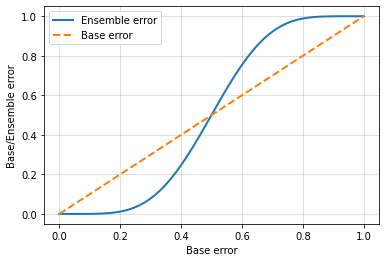

In [6]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

import matplotlib.pyplot as plt

plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
# plt.savefig('images/07_03.png', dpi=300)
plt.show()

앙상블의 에러확률은 개별 분류기보다 항상 좋다.
다만 분류기가 무작위 추측보다 성능이 좋아야 한다. 

y축은 분류기 에러(점선)와 앙상블 에어(실선)을 나타냄

# 다수결 투표를 사용한 분류 앙상블



## 간단한 다수결 투표 분류기 구현

다수결 투표에서는 분류 모델의 신뢰도에 가중치를 부여해 연결한다. 

In [7]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

1

넘파이의 average와 argmax 함수를 사용하여 클래스 확률 기반으로 가중치가 적용된 다수결 투표를 구현할 수 있다.

In [8]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [9]:
np.argmax(p)

0

이들을 모두 결합하여 MajorityVoteClassifier 만들기


In [10]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """다수결 투표 앙상블 분류기

    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기
    
    vote : str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
        'probability'면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)
    
    weights : 배열 타입, 크기 = [n_classifiers]
        선택 사항, 기본값: None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
        'weights=None'이면 동일하게 취급합니다

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기를 학습합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬
        
        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터
            
        반환값
        -------
        self : 객체
        
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다'
                             '; 가중치 %d 개, 분류기 %d 개'
                             % (len(self.weights), len(self.classifiers)))

        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
# ROC AUC를 계산하기 위해 평균 확률을 반환하는 predict_proba 메서드 추가
    def predict(self, X):
        """X에 대한 클래스 레이블을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬
        
        반환값
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
        
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            # clf.predict 메서드를 사용하여 결과를 모읍니다
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수고 n_features는 특성의 개수인
            샘플 데이터 행렬
        
        반환값
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률
        
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """GridSearch를 위해 분류기의 매개변수 이름을 반환합니다"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

앙상블에 있는 각 분류기의 매개변수에 접근하기 위해 _name_estimators 함수를 사용했고 따로 get_params 매서드를 정의.

---


## 다수결 투표 방식을 사용하여 예측 만들기

나중에 ROC AUC를 계산하기 위해 Iris-versicolor와 Iris-virginica 클래스에 해당하는 샘플만 분류.

In [11]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

#붓꽃 데이터 샘플을 50%는 훈련데이터로 50%는 테스트 데이터로
X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

- 로지스틱 회귀 분류기
- 결정 트리 분류기
- k-최근접 이웃 분류기

이 세가지 분류기로 훈련할것이다

In [12]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


각 분류기의 예측 성능은 거의 비슷하단것을 알수있다. 

로지스틱 회귀와 k-최근접 이웃 분류기는 왜 파이프라인으로 훈련?

-> 로지스틱 회귀와 유클라디안 거리를 사용하는 k-최근접 이웃 알고리즘은 결정트리와 달리 스케일에 민감하다. 

붓꽃 데이터셋의 특성이 모두 같은 스케일로 측정되었지만 특성을 표준화하는 것은 좋은 습관이다.

In [13]:
# 다수결 투표 앙상블을 위해 MajorityVoteClassifier 클래스로 각 분류기를 하나로 연결

# 다수결 (하드) 투표

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


사이킷런의 `VotingClassifier`를 사용해 보겠습니다. `estimators` 매개변수에는 분류기 이름과 객체로 구성된 튜플의 리스트를 입력합니다. 앞에서 만든 `MajorityVoteClassifier`는 `vote` 매개변수에 상관없이 `predict_proba` 메서드를 실행할 수 있지만 사이킷런의 `VotingClassifier`는 `voting='hard'`일 경우 `predict_proba` 메서드를 지원하지 않습니다. ROC AUC를 계산하기 위해서는 예측 확률이 필요하므로 `voting='soft'`로 지정합니다.

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')

scores = cross_validate(estimator=vc, X=X_train, y=y_train, 
                        cv=10, scoring='roc_auc')
print("ROC AUC: : %0.2f (+/- %0.2f) [%s]"
      % (scores['test_score'].mean(), 
         scores['test_score'].std(), 'VotingClassifier'))

ROC AUC: : 0.98 (+/- 0.05) [VotingClassifier]


`VotingClassifier`의 `fit` 메서드를 호출할 때 진행 과정을 출력하려면 0.23버전에서 추가된 `verbose` 매개변수를 `True`로 지정해야 합니다. 여기에서는 앞서 만든 `vc` 객체의 `set_params` 메서드를 사용해 `verbose` 매개변수를 설정하겠습니다.

In [15]:
vc.set_params(verbose=True)

vc = vc.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing lr, total=   0.0s
[Voting] ....................... (2 of 3) Processing dt, total=   0.0s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s


`voting='soft'`일 때 `predict` 메서드는 `predict_proba` 메서드에서 얻은 가장 큰 확률의 클래스를 예측으로 삼습니다. `predict_proba` 메서드는 각 분류기의 클래스 확률을 평균합니다.

In [16]:
vc.predict_proba(X_test[:10])

array([[0.80858947, 0.19141053],
       [0.80798659, 0.19201341],
       [0.80742142, 0.19257858],
       [0.81176637, 0.18823363],
       [0.81195778, 0.18804222],
       [0.17701319, 0.82298681],
       [0.17670572, 0.82329428],
       [0.17845724, 0.82154276],
       [0.1796252 , 0.8203748 ],
       [0.81076201, 0.18923799]])

## 앙상블 분류기의 평가와 튜닝

본 적 없는 데이터에 대한 MajorityVoteClassifier의 일반화 성능을 확인하기 위해 테스트 데이터셋에 대한 ROC 곡선을 그려볼것이다. 

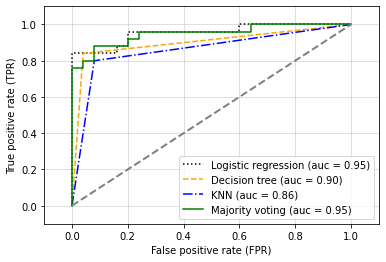

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # 양성 클래스의 레이블이 1이라고 가정합니다
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


# plt.savefig('images/07_04', dpi=300)
plt.show()

앙상블 분류기는 테스트 데이터셋에서도 좋은 성늘을 낸다. 

로지스틱 회귀도 같은 데이터에서 비슷한 성능을 내고 있다. -> 아마도 작은 데이터셋에서 생기는 높은 분산 때문

이 분류 문제에서는 두 개의 특성만 선택했기 때문에 앙상블의 결정 경계가 어떤 모습인지 확인해볼 수 있다. 



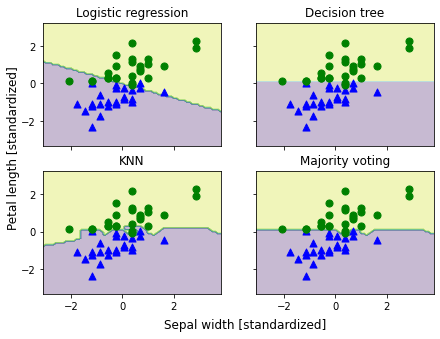

In [18]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

# plt.savefig('images/07_05', dpi=300)
plt.show()

앙상블을 위해 개별 분류기의 매개변수를 튜닝하기 전에 GridSearchCV 객체 안에 있는 매개변수에 어떻게 접근할 수 있는지 get_params 메서드를 호출해서 알아보겠다.

In [19]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_int

그리드 서치로 로지스틱 회귀 분류기의 규제 매개변수 C와 결정트리의 깊이를 튜닝

In [20]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [21]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
정확도: 0.98


규제 강도가 가장 낮을 때 c=0.001 최상의 교차검증 결과를 얻었다. 

반면 트리 깊이는 성능에 전혀 영향을 주지 않았다. 

# 배깅: 부트스트랩 샘플링을 통한 분류 앙상블

앙상블에 있는 개별 분류기를 통일한 훈련 데이터셋으로 학습하는 것이 아니라 원본 훈련 데이터셋에서 부트스트랩 (bootstrap) 샘플 (중복을 허용한 랜덤 샘플)을 뽑아서 사용한다. 



In [22]:
Image(url='https://git.io/Jtsk4', width=500) 

## 배깅 알고리즘의 작동방식

1. 우선, 데이터로부터 부트스트랩을 한다. 
2. 복원 랜덤 샘플링/ 부트스트랩한 데이터로 모델을 학습시킨다. 
3. 학습된 모델의 결과를 집계하여 최종 결과값을 구한다.

categorical data는 투표방식으로 결과를 집계, continuous data는 평균으로 집계




In [23]:
Image(url='https://git.io/JtskB', width=400) 

개별 분류기가 부트스트랩 샘플에 학습되고 나면 다수결 투표를 사용하여 예측을 모은다. 

## 배깅으로 Wine 데이터셋의 샘플 분류



In [24]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# UCI 머신 러닝 저장소에서 Wine 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요:

# df_wine = pd.read_csv('wine.data', header=None)

# 클래스 1 제외
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [27]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (bag_train, bag_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833
배깅의 훈련 정확도/테스트 정확도 1.000/0.917


가지치기가 없는 결정트리는 모든 훈련 샘플을 정확하게 예측한다. 

테스트 데이터셋의 정확도는 확실히 낮기 때문에 모델의 분산이 높다는 것(과대적합)을 나타냄


**결정트리와 배깅 분류기의 훈련 정확도가 훈련 데이터셋에서 비슷하지만 테스트 테이터셋의 정확도로 미루어 보아 배깅 분류기가 일반화 성능이 더 낫다.**

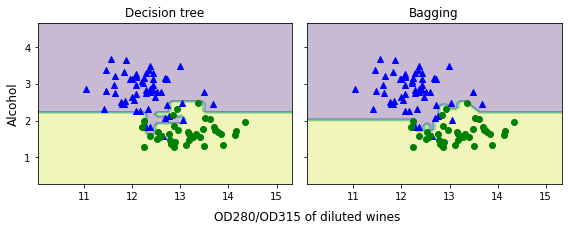

In [28]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

**배깅 앙상블에서 더 부드러워졌다**

실전에서 고차원 데이터셋을 사용하는 더 복잡한 분류 문제라면 단일 결정트리가 쉽게 과대적합될 수 있다.-> 이런 경우에 배깅 알고리즘의 강력함이 제대로 발휘될 수 있다. 

배깅 알고리즘은 모델의 분산을 감소하는 효과적인 방법이지만 모델의 편향을 낮추|는 데는 효과적이지 않다. 

**즉, 모델이 너무 단순해서 데이터에 있는 경향을 잘 잡아내지 못한다.**



배깅의 OOB 점수 계산 방식은 랜덤 포레스트와 거의 동일합니다. 다만 `base_estimator`에 지정된 분류기가 `predict_proba` 메서드를 지원하지 않을 경우 예측 클래스를 카운팅하여 가장 높은 값의 클래스를 사용해 정확도를 계산합니다. 본문에서 만든 것과 동일한 `BaggingClassifier` 모델를 만들고 OOB 점수를 계산해 보겠습니다.

In [29]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        oob_score=True,
                        random_state=1)
bag.fit(X_train, y_train)

bag_train_score = bag.score(X_train, y_train)
bag_test_score = bag.score(X_test, y_test)
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' % 
      (bag_train_score, bag_test_score))
print('배깅의 OOB 정확도 %.3f' % bag.oob_score_)

배깅의 훈련 정확도/테스트 정확도 1.000/0.917
배깅의 OOB 정확도 0.895


# 약한 학습기를 이용한 에이다부스트

가장 유명한 구현인 **에이다부스트**에 대해 설명.

부스팅에서 앙상블은 **약한 학습기**라고도 하는 매우 간단한 분류기로 구성된다. 

이 분류기는 랜덤추측보다 조금 성능이 좋을 뿐이다. 

약한 학습기의전형적인 예는 깊이가 1인 결정 트리이다. 부스팅의 핵심 아이디어는 분류하기 어려운 훈련 샘플에 초점을 맞추는 것,

**잘못 분류된 훈련 샘플을 그 다음 약한 학습기가 학습하여 앙상블 성능을 향상시킨다**


## 부스팅 작동 원리

1. 훈련 데이터셋 $D$에서 중복을 혀용하지 않고 랜덤한 부분 집합 $d_1$을 뽑아 약한 학습기 $C_1$을 훈련한다. 
2. 훈련 데이터셋에서 중복을 허용하지 않고 두 번째 랜덤한 훈련 부분 집합 $d_2$를 뽑고 이전에 잘못 분류된 샘플의 50%을 더해서 약한 학습기 $C_2$를 훈련시킨다. 
3. 훈련 데이터셋 $D$에서 $C_1$과 $C_2$에서 잘못 분류된 훈련 샘플 $d_3$를 찾아 세번째 약한 학습기인 $C_2$를 훈련시킨다. 
4. 약한 학습기 $C_1, C_2,C_3$를 다수결 투표로 연결한다. 
---
부스팅은 배깅 모델에 비해 분산은 물론 편향도 감소시킬수 있다. 

실제로는 에이다부스트 같은 부스팅 알고리즘이 분산이 높다고 알려져있다-> 훈련 데이터에 과대적합되는 경향이 있다. 

훈련 샘플은 반복마다 가중치가 다시 부여되며 이 앙상블은 이전 학습기의 실수를 학습하는 강력한 분류기를 만든다. 




In [31]:
Image(url='https://git.io/Jtsk0', width=400) 

In [32]:
Image(url='https://git.io/Jtskg', width=500) 